In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install datasets wordcloud 
!{sys.executable} pip install --user -U nltk
!pip install scipy gensim==3.8.3

/Users/olohireme/opt/anaconda3/bin/python: can't open file 'pip': [Errno 2] No such file or directory


In [38]:
# importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from datasets import load_dataset
import gensim.downloader as api

In [39]:
# downloading nltk.punkt
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

#### Defining relevant functions

In [40]:
def word_cloud_plot (data):
    """
    function that creates a word cloud from a specified column of a dataframe 
    """
    # create set of stopwords
    stopwords = set(STOPWORDS)

    # Instantiate the word cloud object
    word_cloud = WordCloud(background_color='white',max_words=200,stopwords=stopwords, width=800, height=400)
    
    # generate the word cloud
    word_cloud.generate(' '.join(data))
    
    # To display the word cloud
    plt.figure( figsize=(20,10) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [41]:
def regex_filter(sentence):
    """
    funtion that formats string to remove special characters
    """
    import re
    return re.sub('[^a-zA-Z]', ' ', sentence)

In [42]:
def filter_stop_words(token):
    """
    function that removes stopwords from a word-tokenized sentence
    """
    stop_words = set(stopwords.words('english'))
    filtered_token = [word.lower() for word in token if word.lower() not in stop_words]
    return filtered_token

In [43]:
def stem_words(token):
    """
    function that stems word-tokenized sentences
    """
    ps = PorterStemmer()
    stemmed_token = [ps.stem(word) for word in token]
    return stemmed_token

In [44]:
def lemmatize_words(token):
    """
    function that lemmatizes word-tokenized sentences
    """
    lem = WordNetLemmatizer()
    lemmatized_token = [lem.lemmatize(word, 'v') for word in token]
    return lemmatized_token

In [45]:
def join_token(token):
    """
    function that joins word-tokenized sentences back to single string
    """
    return ' '.join(token)

In [46]:
def get_embeddings(group, model):
    group_embedding = []
    group_labels = []
    
    unique_words = [word for sentence in group for word in sentence]
    unique_words = list(dict.fromkeys(unique_words))
    
    for word in unique_words:
        if model.wv.__contains__(word):
            group_embedding.append(list(model.wv.__getitem__(word)))
            group_labels.append(word)
            
    df_embedding = pd.DataFrame(group_embedding)
    df_word = pd.DataFrame(group_labels, columns = ["Word"])
    df = pd.concat([df_word, df_embedding], axis=1)
    return df

In [47]:
def similarity(words, stem_model=None, lem_model=None, W2V_pretrained=None, GloVe_pretrained=None):
    if stem_model:
        ps = PorterStemmer()
        stemmed = [ps.stem(word) for word in words]
        try:
            print("Stemmed W2V model similarity between", words[0], "and", words[1], "=", stem_model.wv.similarity(stemmed[0], stemmed[1]))
        except:
            print("Error: Word not in stem model vocabulary")
    
    if lem_model:
        lem = WordNetLemmatizer()
        lemma = [lem.lemmatize(word, 'v') for word in words]
        try:
            print("Lemmatized W2V model similarity between", words[0], "and", words[1], "=", lem_model.wv.similarity(lemma[0], lemma[1]))
        except:
            print("Error: Word not in lemmatized model vocabulary")        
    
    if W2V_pretrained:
        try:
            print("Word2vec pretrained model similarity between", words[0], "and", words[1], "=", W2V_pretrained.wv.similarity(words[0], words[1]))
        except:
            print("Error: Word not in Word2vec pretrained model vocabulary")
    
    if GloVe_pretrained:
        try:
            print("GloVe pretrained model similarity between", words[0], "and", words[1], "=", GloVe_pretrained.similarity(words[0], words[1]))
        except:
            print("Error: Word not in GloVe pretrained model vocabulary")    

In [48]:
def tsne_plot(df):
    """
    function that plots annotated scatter plot from a dataframe
    """
    plt.figure(figsize=(18, 18)) 
    for i in range(len(df)):
        plt.scatter(df.iloc[i,1],df.iloc[i,2])
        plt.annotate(df.iloc[i,0],
                     xy=(df.iloc[i,1], df.iloc[i,2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

#### Downloading the dataset

In [49]:
dataset = load_dataset('climate_fever')

df = dataset['test'].to_pandas()
df2 = pd.json_normalize(dataset['test'], 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='Evidence_')

data1 = df[['claim', 'claim_label']]
data2 = df2[['Evidence_evidence','Evidence_evidence_label']]

Using custom data configuration default
Reusing dataset climate_fever (/Users/olohireme/.cache/huggingface/datasets/climate_fever/default/1.0.1/3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [50]:
data1.head()

,claim,claim_label
0,Global warming is driving polar bears toward e...,0
1,The sun has gone into ‘lockdown’ which could c...,0
2,The polar bear population has been growing.,1
3,Ironic' study finds more CO2 has slightly cool...,1
4,Human additions of CO2 are in the margin of er...,1


In [51]:
data2.head()

,Evidence_evidence,Evidence_evidence_label
0,"""Recent Research Shows Human Activity Driving ...",2
1,Environmental impacts include the extinction o...,0
2,Rising temperatures push bees to their physiol...,2
3,"Rising global temperatures, caused by the gree...",0
4,"""Bear hunting caught in global warming debate"".",2


#### Histogram plot of claim labels and evidence labels

<AxesSubplot:xlabel='Evidence_evidence_label', ylabel='Count'>

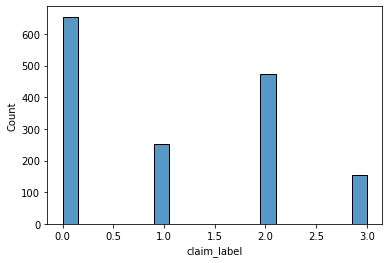

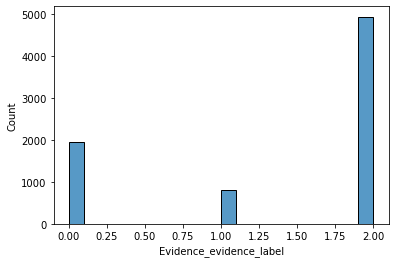

In [52]:
plt.figure()
sns.histplot(data = data1, x ='claim_label', bins = 20)
plt.figure()
sns.histplot(data = data2, x ='Evidence_evidence_label', bins = 20)

#### Word cloud of the claims in the dataset

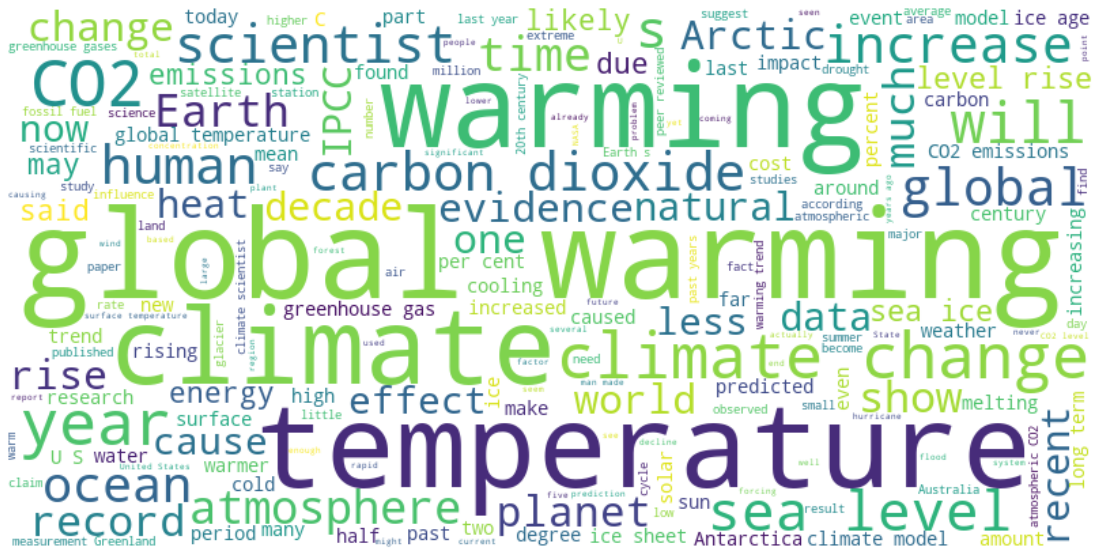

In [53]:
# visualizing word frequency in all claims
word_cloud_plot(data1['claim'])

From the word cloud above, the most common words in claims are global, warming, climate, temperature, change, evidence, C02, scientist, evidence, will(which is a stop word)

#### Data preparation

In [54]:
# filter with regex
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim'].apply(regex_filter)

# Tokenizing the claims
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim_token'].apply(nltk.word_tokenize)

# Removing stop words from the claclaim_tokenim tokens
data1.loc[:,'claim_token'] = data1.loc[:,'claim_token'].apply(filter_stop_words)

# Stemming the words
data1.loc[:,'stemmed_words'] = data1.loc[:,'claim_token'].apply(stem_words)

# lemmatizing the words
data1.loc[:,'lemmatized_words'] = data1.loc[:,'claim_token'].apply(lemmatize_words)

/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [55]:
data1.head()

,claim,claim_label,claim_token,stemmed_words,lemmatized_words
0,Global warming is driving polar bears toward e...,0,"[global, warming, driving, polar, bears, towar...","[global, warm, drive, polar, bear, toward, ext...","[global, warm, drive, polar, bear, toward, ext..."
1,The sun has gone into ‘lockdown’ which could c...,0,"[sun, gone, lockdown, could, cause, freezing, ...","[sun, gone, lockdown, could, caus, freez, weat...","[sun, go, lockdown, could, cause, freeze, weat..."
2,The polar bear population has been growing.,1,"[polar, bear, population, growing]","[polar, bear, popul, grow]","[polar, bear, population, grow]"
3,Ironic' study finds more CO2 has slightly cool...,1,"[ironic, study, finds, co, slightly, cooled, p...","[iron, studi, find, co, slightli, cool, planet]","[ironic, study, find, co, slightly, cool, planet]"
4,Human additions of CO2 are in the margin of er...,1,"[human, additions, co, margin, error, current,...","[human, addit, co, margin, error, current, mea...","[human, additions, co, margin, error, current,..."


#### Word cloud of the claims in the dataset (after data preparation)

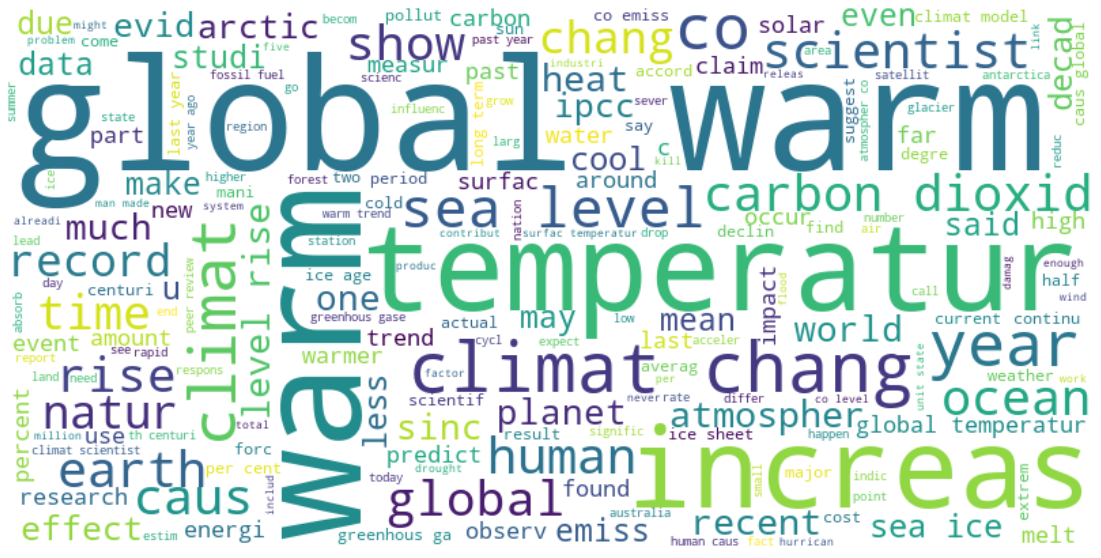

In [56]:
# Visualizing the word cloud again
word_cloud_plot(data1['stemmed_words'].apply(join_token))

Stemming is basically removing the suffix from a word and reduce it to its root word. As we can see from the word cloud above words like nature and increase have hade their suffixes removed. 
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma . 

#### Creating the corpus

In [57]:
from sklearn.model_selection import train_test_split
train_stem, test_stem = train_test_split(data1['stemmed_words'], test_size=0.2, random_state=0)

train_lem, test_lem = train_test_split(data1['lemmatized_words'], test_size=0.2, random_state=0)

#### Training with the whole dataset

In [58]:
# creating the stemmed corpus and lemmatized corpus
corpus_stem = list(data1['stemmed_words'])
corpus_lem = list(data1['lemmatized_words'])

In [59]:
# getting the length of unique stemmed words
unique_set = [word for token in corpus_stem for word in token]
unique_set = set(unique_set)
len(unique_set)

2962

In [60]:
# getting the length of unique lemmatized words
unique_set2 = [word for token in corpus_lem for word in token]
unique_set2 = set(unique_set2)
len(unique_set2)

3324

#### Building the Word2Vec model

In [61]:
# Embeding with Word2Vec
model_stem_claim = Word2Vec(corpus_stem, min_count=1)
model_lem_claim = Word2Vec(corpus_lem, min_count=1)
print(model_stem_claim)
print(model_lem_claim)

Word2Vec(vocab=2962, size=100, alpha=0.025)
Word2Vec(vocab=3324, size=100, alpha=0.025)


In [62]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global']]

In [63]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9813919
Lemmatized W2V model similarity between man and bear = 0.9643383

Stemmed W2V model similarity between heat and warm = 0.998067
Lemmatized W2V model similarity between heat and warm = 0.9969095

Stemmed W2V model similarity between climate and weather = 0.9962796
Lemmatized W2V model similarity between climate and weather = 0.9944861

Stemmed W2V model similarity between earth and global = 0.997323
Lemmatized W2V model similarity between earth and global = 0.99479115



#### Adding the evidences to the corpus

In [64]:
# Adding the evidences to increase corpus size

# filer with regex
data2.loc[:, ('evidence_token')] = data2.loc[:, ('Evidence_evidence')].apply(regex_filter)

# Tokenizing the claims
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence_token')].apply(nltk.word_tokenize)

# Removing stop words from the evidence_token tokens
data2.loc[:,('evidence_token')] = data2.loc[:,('evidence_token')].apply(filter_stop_words)

# Stemming the words
data2.loc[:,('stemmed_words')] = data2.loc[:,('evidence_token')].apply(stem_words)

# lemmatizing the words
data2.loc[:,('lemmatized_words')] = data2.loc[:,('evidence_token')].apply(lemmatize_words)

/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [65]:
data2.head()

,Evidence_evidence,Evidence_evidence_label,evidence_token,stemmed_words,lemmatized_words
0,"""Recent Research Shows Human Activity Driving ...",2,"[recent, research, shows, human, activity, dri...","[recent, research, show, human, activ, drive, ...","[recent, research, show, human, activity, driv..."
1,Environmental impacts include the extinction o...,0,"[environmental, impacts, include, extinction, ...","[environment, impact, includ, extinct, reloc, ...","[environmental, impact, include, extinction, r..."
2,Rising temperatures push bees to their physiol...,2,"[rising, temperatures, push, bees, physiologic...","[rise, temperatur, push, bee, physiolog, limit...","[rise, temperatures, push, be, physiological, ..."
3,"Rising global temperatures, caused by the gree...",0,"[rising, global, temperatures, caused, greenho...","[rise, global, temperatur, caus, greenhous, ef...","[rise, global, temperatures, cause, greenhouse..."
4,"""Bear hunting caught in global warming debate"".",2,"[bear, hunting, caught, global, warming, debate]","[bear, hunt, caught, global, warm, debat]","[bear, hunt, catch, global, warm, debate]"


#### Word cloud of the evidences in the dataset (after data preparation)

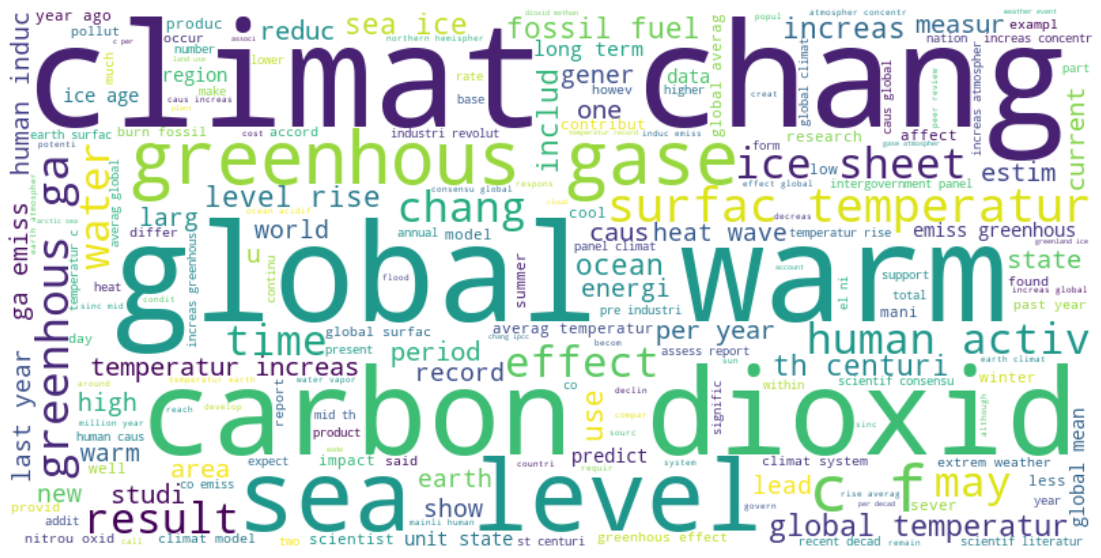

In [66]:
# Visualizing the word cloud of the evidences
word_cloud_plot(data2['stemmed_words'].apply(join_token))

#### Adding the evidences to the corpus

In [67]:
df_stem = pd.concat([data1['stemmed_words'], data2['stemmed_words']])
df_lem = pd.concat([data1['lemmatized_words'], data2['lemmatized_words']])

In [68]:
df_stem.head()

0    [global, warm, drive, polar, bear, toward, ext...
1    [sun, gone, lockdown, could, caus, freez, weat...
2                           [polar, bear, popul, grow]
3      [iron, studi, find, co, slightli, cool, planet]
4    [human, addit, co, margin, error, current, mea...
Name: stemmed_words, dtype: object

In [69]:
df_lem.head()

0    [global, warm, drive, polar, bear, toward, ext...
1    [sun, go, lockdown, could, cause, freeze, weat...
2                      [polar, bear, population, grow]
3    [ironic, study, find, co, slightly, cool, planet]
4    [human, additions, co, margin, error, current,...
Name: lemmatized_words, dtype: object

In [70]:
from sklearn.model_selection import train_test_split
train_stem, test_stem = train_test_split(df_stem, test_size=0.2, random_state=0)

train_lem, test_lem = train_test_split(df_lem, test_size=0.2, random_state=0)

In [71]:
# adding the sentences in the evidence to the corpus
corpus_stem = list(df_stem)
corpus_lem = list(df_lem)

In [72]:
# getting the length of unique stemmed words
unique_set3 = [word for token in corpus_stem for word in token]
unique_set3 = set(unique_set3)
len(unique_set3)

7433

In [124]:
unique_set3

{'nitrat',
 'automat',
 'higher',
 'convey',
 'reflex',
 'pivot',
 'long',
 'leverag',
 'eel',
 'freight',
 'jason',
 'releas',
 'lattic',
 'bau',
 'sever',
 'shermer',
 'boom',
 'slip',
 'eric',
 'noxiou',
 'citi',
 'symbiot',
 'cambrian',
 'au',
 'orbit',
 'isl',
 'anyadik',
 'third',
 'brave',
 'kangaroo',
 'outbreak',
 'besid',
 'scrap',
 'sludg',
 'cere',
 'montreal',
 'ox',
 'get',
 'lovelock',
 'pure',
 'shell',
 'leonard',
 'leeway',
 'marshland',
 'ch',
 'ecologist',
 'commonli',
 'dress',
 'dot',
 'paso',
 'nato',
 'historian',
 'pennsylvania',
 'tasteless',
 'ethiopia',
 'statistician',
 'race',
 'berlin',
 'chief',
 'arid',
 'revit',
 'rail',
 'myzotrophi',
 'power',
 'irregularli',
 'norfolk',
 'breakthrough',
 'tomorrow',
 'hydrofractur',
 'capit',
 'wmap',
 'eg',
 'ship',
 'koshay',
 'morn',
 'row',
 'cautious',
 'disproportion',
 'gwp',
 'trudeau',
 'western',
 'misquot',
 'inhg',
 'gross',
 'mississippi',
 'ptolemi',
 'seep',
 'gsl',
 'consum',
 'seymour',
 'fiber',
 '

In [90]:
# getting the length of unique lemmatized words
unique_set4 = [word for token in corpus_lem for word in token]
unique_set4 = set(unique_set4)
len(unique_set4)

9055

In [92]:
unique_set4

{'unconvincing',
 'tonne',
 'higher',
 'attitude',
 'convey',
 'industrialize',
 'michaels',
 'rigorously',
 'long',
 'freight',
 'orthography',
 'jason',
 'immediacy',
 'polluter',
 'programmable',
 'descriptions',
 'bau',
 'certainly',
 'shermer',
 'boom',
 'slip',
 'eric',
 'productive',
 'enterprise',
 'cambrian',
 'au',
 'smelters',
 'orbit',
 'genuine',
 'remote',
 'status',
 'rat',
 'third',
 'effectively',
 'activity',
 'brave',
 'prominence',
 'kangaroo',
 'outbreak',
 'centrally',
 'scrap',
 'cere',
 'montreal',
 'ox',
 'preliminary',
 'get',
 'lovelock',
 'externally',
 'pure',
 'specially',
 'shell',
 'spurious',
 'administrative',
 'leonard',
 'leeway',
 'disparity',
 'ch',
 'ecologist',
 'homeostasis',
 'dress',
 'dot',
 'forcers',
 'paso',
 'desire',
 'nato',
 'reintroduce',
 'elimination',
 'premiums',
 'ramces',
 'historian',
 'pennsylvania',
 'diabetes',
 'tasteless',
 'ethiopia',
 'rockies',
 'statistician',
 'race',
 'towns',
 'berlin',
 'intrude',
 'chief',
 'arid'

#### Building the Word2Vec model

In [74]:
# Embeding with Word2Vec
model_stem_total = Word2Vec(corpus_stem, min_count=1)
model_lem_total = Word2Vec(corpus_lem, min_count=1)
print(model_stem_total)
print(model_lem_total)

Word2Vec(vocab=7433, size=100, alpha=0.025)
Word2Vec(vocab=9055, size=100, alpha=0.025)


In [75]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_total, 
               lem_model = model_lem_total
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9129743
Lemmatized W2V model similarity between man and bear = 0.96465033

Stemmed W2V model similarity between heat and warm = 0.7005036
Lemmatized W2V model similarity between heat and warm = 0.6737721

Stemmed W2V model similarity between climate and weather = 0.6969937
Lemmatized W2V model similarity between climate and weather = 0.6681219

Stemmed W2V model similarity between earth and global = 0.9438189
Lemmatized W2V model similarity between earth and global = 0.92598236



#### Comparing with pretrained models

In [76]:
# Loading pretrained Word2Vec model
w2v_data = api.load("text8")
W2V_pretrained = Word2Vec(w2v_data)

In [77]:
# Loading pretrained GloVe model
GloVe_pretrained = api.load("glove-wiki-gigaword-50")

In [78]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_total, 
               lem_model = model_lem_total, 
               W2V_pretrained = W2V_pretrained, 
               GloVe_pretrained = GloVe_pretrained
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9129743
Lemmatized W2V model similarity between man and bear = 0.96465033
Word2vec pretrained model similarity between man and bear = 0.29378402
GloVe pretrained model similarity between man and bear = 0.5815115

Stemmed W2V model similarity between heat and warm = 0.7005036
Lemmatized W2V model similarity between heat and warm = 0.6737721
Word2vec pretrained model similarity between heat and warm = 0.5364655
GloVe pretrained model similarity between heat and warm = 0.68190837

Stemmed W2V model similarity between climate and weather = 0.6969937
Lemmatized W2V model similarity between climate and weather = 0.6681219
Word2vec pretrained model similarity between climate and weather = 0.62489384
GloVe pretrained model similarity between climate and weather = 0.67468363

Stemmed W2V model similarity between earth and global = 0.9438189
Lemmatized W2V model similarity between earth and global = 0.92598236
Word2vec pretrained model simila

### Performance of our model vs Pre-trained Models

-

-

In [79]:
model_stem_total.wv['climat']

array([ 0.43007413, -0.00338325, -0.9230537 ,  0.09394012, -0.2630714 ,
        0.5498333 , -0.01272015,  0.02342218, -0.21799588,  0.5229808 ,
       -0.3539203 , -0.06811602,  0.49606118, -0.42195326,  0.7116929 ,
       -0.6602146 ,  0.67230254,  0.17271559, -0.96511763,  0.5674741 ,
        0.4261558 ,  0.803195  , -0.48277584, -0.18510991, -0.29957032,
       -1.0381852 , -1.3724558 ,  0.29845425, -0.22215433, -0.35485432,
       -0.01495298, -1.1337491 , -0.7624562 , -0.85991764, -0.17335042,
        0.4906272 ,  1.059256  ,  0.38101697,  0.5341482 , -0.15714854,
        0.588341  , -0.50582224, -0.05896031,  0.30770648,  0.46635255,
       -0.07592729,  0.8214871 ,  0.99559224, -0.04057187, -0.15089718,
        0.14998528,  0.574335  , -0.8393197 ,  0.8850906 ,  0.35920468,
       -0.6548492 ,  0.22617464, -0.16258231, -0.30158356,  0.90597135,
        0.3346401 ,  0.3395892 , -0.99285156,  0.27335227, -0.04892723,
       -0.57680786,  0.8673419 , -0.60865194,  1.150484  , -0.75

In [80]:
len(model_stem_total.wv.vocab)

7433

In [81]:
train_embedding_stem = get_embeddings(train_stem, model_stem_total)
train_embedding_stem.head()

,Word,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,includ,0.156148,0.276736,-0.613944,0.032771,-0.278488,0.177161,-0.034528,0.187064,-0.130171,...,0.235081,-0.033110,0.180780,-0.632394,-0.050915,-0.264894,-0.290654,-0.144287,-0.682573,0.036304
1,process,-0.185888,0.302531,-0.411561,-0.023176,-0.105032,0.219419,-0.069947,0.004830,-0.118936,...,0.205398,0.087632,0.312004,-0.672248,-0.069836,-0.155935,-0.179535,-0.016781,-0.610883,-0.275714
2,variat,-0.055576,0.065674,-0.391314,-0.230267,-0.145815,0.470973,-0.220865,-0.015074,-0.081126,...,0.221529,0.079341,0.129915,-0.315744,-0.035554,0.033714,0.077700,0.150456,-0.533940,-0.240339
3,solar,-0.397907,0.363895,-0.431602,-0.095607,-0.103585,0.314194,0.059343,-0.250853,-0.177715,...,0.141379,0.153380,0.297105,-0.885138,-0.172708,-0.226898,-0.220131,0.070205,-0.757124,-0.383062
4,radiat,-0.401180,0.417481,-0.463947,0.024866,-0.057825,0.219221,-0.157292,-0.000576,-0.080078,...,0.476763,-0.056530,0.302884,-0.657063,-0.092164,-0.194940,-0.030968,-0.055045,-0.572371,-0.404460


In [82]:
train_embedding_lem = get_embeddings(train_lem, model_lem_total)
train_embedding_lem.head()

,Word,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,include,0.189205,-0.096993,-0.509369,0.278297,-0.233922,0.672001,0.267379,-0.112589,-0.008310,...,0.552574,0.102784,-0.201615,0.152727,0.503471,0.187777,0.640399,0.250732,-0.312731,-0.187440
1,process,0.088240,-0.027500,-0.207328,0.035834,-0.119348,0.889775,0.229737,-0.205063,-0.293428,...,0.444695,0.202394,-0.344868,0.146491,0.423918,0.163132,0.648559,0.251702,-0.289735,-0.436522
2,variations,0.056069,-0.042140,-0.133637,-0.067053,-0.132383,0.740294,0.098894,-0.197129,0.019483,...,0.278516,0.146326,-0.313743,0.185533,0.259468,0.088896,0.515655,0.262250,-0.184455,-0.227377
3,solar,-0.001881,-0.172625,-0.151526,0.099686,-0.108475,1.101148,0.325316,-0.400902,-0.389554,...,0.447614,0.333702,-0.427935,0.096370,0.415846,0.175024,0.766677,0.396859,-0.385554,-0.588553
4,radiation,0.105299,0.158698,-0.165479,-0.159027,-0.203582,0.912786,0.284959,-0.207162,-0.108990,...,0.624887,0.078413,-0.376347,0.394468,0.431856,0.029256,0.693153,0.188335,-0.186517,-0.322352


#### Getting the test set embeddings

In [83]:
test_embedding_stem = get_embeddings(list(test_stem), model_stem_total)
test_embedding_stem.head()

,Word,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,choic,0.001806,0.018086,-0.052409,-0.048722,-0.021432,0.081855,-0.016235,0.009537,-0.023507,...,0.031179,0.032535,0.042002,-0.067124,0.014417,0.002476,-0.005145,0.046574,-0.094110,-0.030552
1,author,0.075134,0.056663,-0.311835,-0.212604,-0.119217,0.435878,-0.090108,0.048892,-0.087400,...,0.094775,0.153760,0.137641,-0.361398,0.056413,0.038967,-0.004651,0.175024,-0.474789,-0.150066
2,aim,0.016186,0.039384,-0.171861,-0.119531,-0.064658,0.227916,-0.051421,0.016446,-0.045555,...,0.062888,0.088125,0.073857,-0.183547,0.022445,0.022746,0.002890,0.115792,-0.258678,-0.088701
3,rang,0.216195,0.037221,-0.508496,-0.410702,-0.298181,0.841982,-0.414647,0.181663,0.029822,...,0.419192,0.027061,0.047728,-0.049380,0.109525,0.150606,0.314178,0.447390,-0.531302,-0.041815
4,view,0.133288,-0.018049,-0.265465,-0.184768,-0.099527,0.341701,-0.125529,0.049561,-0.066322,...,0.061748,0.117361,0.046181,-0.185236,0.028848,0.061218,0.033031,0.084390,-0.345194,-0.114205


In [84]:
test_embedding_lem = get_embeddings(list(test_lem), model_lem_total)
test_embedding_lem.head()

,Word,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,choice,0.003501,-0.010652,-0.009456,-0.007522,-0.018991,0.083533,-0.004418,-0.019717,0.009665,...,0.020662,0.021248,-0.035658,0.012778,0.026351,0.012840,0.059051,0.043542,-0.018950,-0.026596
1,author,0.038115,-0.086436,-0.093074,0.007909,-0.088484,0.586124,0.004308,-0.139733,0.025950,...,0.112936,0.136999,-0.250735,0.099268,0.204552,0.113717,0.416437,0.206613,-0.184011,-0.170201
2,aim,0.009725,-0.046924,-0.066413,-0.007325,-0.061562,0.406630,0.031175,-0.114852,-0.012274,...,0.104016,0.091441,-0.184451,0.076787,0.154577,0.078588,0.293471,0.150622,-0.131406,-0.150387
3,range,0.076698,0.129441,-0.223740,-0.373291,-0.414750,1.069871,-0.103636,-0.250226,0.709599,...,0.446549,0.044543,-0.536123,0.492589,0.365503,-0.050977,0.774951,0.484352,-0.192709,0.017170
4,view,0.019528,-0.079666,-0.102425,0.010210,-0.078774,0.548601,-0.011540,-0.140293,0.059696,...,0.068517,0.108093,-0.247737,0.112468,0.170074,0.113496,0.394624,0.179813,-0.174408,-0.146790


### Arithmetic Relationships

In [137]:
#Relationship 1
#ICE + WARM - COLD = WATER/SEA/OCEAN
model_stem_total.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('rise', 0.8865717649459839),
 ('level', 0.874081552028656),
 ('ocean', 0.8237444162368774),
 ('increas', 0.8182587027549744),
 ('acceler', 0.8061689138412476)]

In [138]:
model_lem_total.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('rise', 0.8853082060813904),
 ('level', 0.878996729850769),
 ('sea', 0.8702519536018372),
 ('arctic', 0.8531848192214966),
 ('ocean', 0.8461861610412598)]

In [139]:
#Relationship 2
#dark + sun - night = day/light
model_stem_total.wv.most_similar(positive=['hydro', 'gase'], negative=['carbon'],  topn=5)

[('endors', 0.9709709882736206),
 ('magnitud', 0.9706813097000122),
 ('accur', 0.9691089391708374),
 ('variabl', 0.9690594673156738),
 ('commun', 0.9654930830001831)]

In [140]:
model_lem_total.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

[('impact', 0.9767329692840576),
 ('accurately', 0.9744117259979248),
 ('variability', 0.9742111563682556),
 ('hothouse', 0.9741145372390747),
 ('components', 0.9740463495254517)]

In [141]:
#Relationship 3
#rising + gradual - increasing = slow
model_stem_total.wv.most_similar(positive=['rise', 'gradual'], negative=['increas'],  topn=5)

[('shrunk', 0.9690986275672913),
 ('ft', 0.9679548144340515),
 ('outflow', 0.9568570852279663),
 ('retreat', 0.9565737247467041),
 ('centimet', 0.9553824663162231)]

In [142]:
#rising + gradual - increasing
model_lem_total.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('sea', 0.949702799320221),
 ('shrinkage', 0.9418675303459167),
 ('arctic', 0.9352383017539978),
 ('antarctic', 0.9306426048278809),
 ('melt', 0.9300088882446289)]

In [143]:
#Relationship 4
#summer + cold - solar = winter
model_stem_total.wv.most_similar(positive=['north', 'pole'], negative=['arctic'],  topn=5)

[('northernmost', 0.975016713142395),
 ('everi', 0.9743521213531494),
 ('januari', 0.9712028503417969),
 ('pari', 0.9710389971733093),
 ('june', 0.9710171818733215)]

In [144]:
model_lem_total.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=5)

[('extratropical', 0.9724429249763489),
 ('georgia', 0.971544623374939),
 ('compute', 0.971533477306366),
 ('triassic', 0.9708907604217529),
 ('every', 0.9673211574554443)]

In [145]:
#Relationship 5
#climate + temperature - weather
model_stem_total.wv.most_similar(positive=['climat', 'temperatur'], negative=['weather'],  topn=5)

[('consensu', 0.8817325830459595),
 ('overwhelm', 0.8728915452957153),
 ('global', 0.8673504590988159),
 ('warm', 0.8485745191574097),
 ('recent', 0.8447917699813843)]

In [146]:
model_lem_total.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

[('potentials', 0.9199665188789368),
 ('unequivocal', 0.890825629234314),
 ('observe', 0.8806520104408264),
 ('consensus', 0.8731130957603455),
 ('personally', 0.8728175163269043)]

In [147]:
W2V_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

[('rocks', 0.6681491732597351),
 ('snow', 0.6446545124053955),
 ('dry', 0.6293928623199463),
 ('glacier', 0.6246801614761353),
 ('beds', 0.6241227984428406)]

In [148]:
GloVe_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

<ipython-input-148-1ec3bbdb9b68>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)


[('plate', 0.7150593996047974),
 ('silver', 0.6485081911087036),
 ('sparkling', 0.636193573474884),
 ('skate', 0.6235347986221313),
 ('cream', 0.6151865720748901)]

In [149]:
W2V_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

[('electricity', 0.605630099773407),
 ('liquified', 0.6004489660263062),
 ('petrol', 0.5885313153266907),
 ('tanker', 0.5673044919967651),
 ('uprated', 0.5541200637817383)]

In [150]:
GloVe_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

<ipython-input-150-2ba09357030c>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)


[('statoil', 0.7187291383743286),
 ('pipeline', 0.6830664873123169),
 ('refinery', 0.6819669008255005),
 ('hydroelectric', 0.6683335304260254),
 ('electricity', 0.6475889682769775)]

In [151]:
W2V_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('emergence', 0.599249005317688),
 ('modernism', 0.5880670547485352),
 ('postwar', 0.5581912994384766),
 ('radicalization', 0.5279842615127563),
 ('drastic', 0.5239071249961853)]

In [152]:
GloVe_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

<ipython-input-152-026c8898a0fe>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)


[('inexorable', 0.7363816499710083),
 ('upturn', 0.7345753908157349),
 ('precipitous', 0.725489616394043),
 ('stagnation', 0.7136895060539246),
 ('downward', 0.6995311379432678)]

In [135]:
W2V_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)

[('south', 0.6486576795578003),
 ('west', 0.5369924902915955),
 ('nisjoki', 0.46729016304016113)]

In [136]:
GloVe_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)

<ipython-input-136-7d315d12d06e>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)


[('fifth', 0.7316383719444275),
 ('third', 0.7275133728981018),
 ('sixth', 0.7260597348213196)]

In [153]:
W2V_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

[('enthalpy', 0.626967191696167),
 ('temperatures', 0.6249064207077026),
 ('humidity', 0.5825331211090088),
 ('pressures', 0.5737169981002808),
 ('density', 0.567017138004303)]

In [154]:
GloVe_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

<ipython-input-154-92ac769b420e>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)


[('carbon', 0.7083598375320435),
 ('warming', 0.6987556219100952),
 ('greenhouse', 0.680810809135437),
 ('co2', 0.6696141958236694),
 ('ph', 0.6661812663078308)]

## PCA

### Using Stemming

In [48]:
from sklearn.decomposition import PCA
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
explained_variance = []
log_likelihood = []
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit_transform(train_embedding_stem.iloc[:,1:].values)
    explained_variance.append(1 - sum(pca.explained_variance_ratio_))
    log_likelihood.append(pca.score(train_embedding_stem.iloc[:,1:].values))

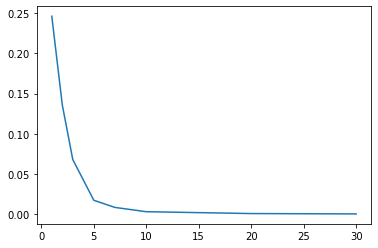

In [49]:
plt.plot(n_components, explained_variance)

Explained variance tells us how much information can be attributed to each of the principal components. The explained variance reduces as the number of components increases which shows that most of the information is held by the first 5 components. 
The "elbow" of the graph where the eigenvalues seem to level off is found and factors or components to the left of this point should be retained as significant.
The plot above shows the unexplained variance, i.e. the information not explained by the cumulative number of components on the x-axix. This reduces as the cumulative number of components increases.

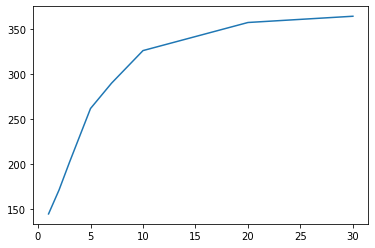

In [50]:
plt.plot(n_components, log_likelihood)

In [51]:
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_stem.iloc[:,1:].values)
pca_test = pca.transform(test_embedding_stem.iloc[:,1:].values)

In [52]:
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5']
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test["Word"] = test_embedding_stem["Word"]
pca_test = pca_test[['Word','PC_1','PC_2','PC_3','PC_4','PC_5']]
pca_test.head()

,Word,PC_1,PC_2,PC_3,PC_4,PC_5
0,choic,-0.074436,0.024169,-0.056370,-0.004259,0.015531
1,author,2.700942,0.077116,-0.728429,-0.226496,0.003908
2,aim,1.094046,0.042917,-0.194266,-0.161302,0.062141
3,rang,4.031717,-1.839536,0.310985,-0.389347,-0.061425
4,view,1.886003,-0.181501,-0.402944,-0.387041,-0.116014


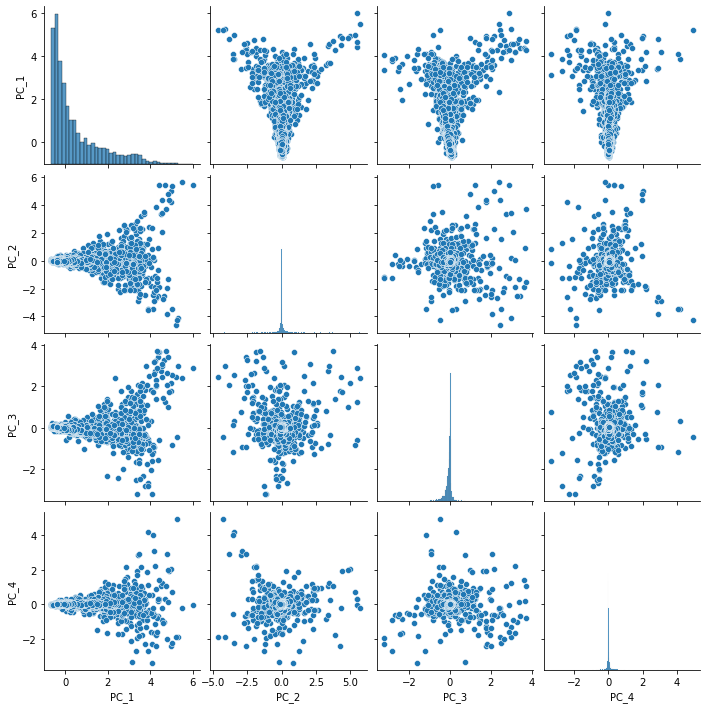

In [53]:
sns.pairplot(pca_test.iloc[:,1:5])

### Using Lemmatization

In [54]:
explained_variance = []
log_likelihood = []
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit_transform(train_embedding_lem.iloc[:,1:].values)
    explained_variance.append(1 - sum(pca.explained_variance_ratio_))
    log_likelihood.append(pca.score(train_embedding_lem.iloc[:,1:].values))

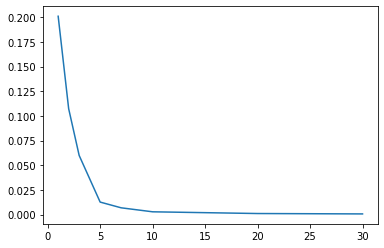

In [55]:
plt.plot(n_components, explained_variance)

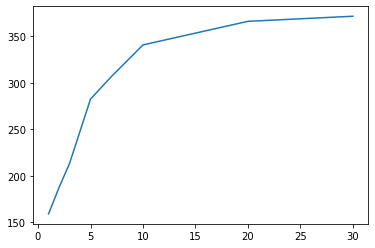

In [56]:
plt.plot(n_components, log_likelihood)

In [57]:
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_lem.iloc[:,1:].values)
pca_test = pca.transform(test_embedding_lem.iloc[:,1:].values)

In [58]:
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test["Word"] = test_embedding_lem["Word"]
pca_test = pca_test[['Word','PC_1','PC_2','PC_3','PC_4','PC_5']]
pca_test.head()

,Word,PC_1,PC_2,PC_3,PC_4,PC_5
0,choice,-0.168652,0.040906,-0.012687,-0.010321,0.001214
1,author,2.149379,0.079192,-0.482398,-0.189387,0.015091
2,aim,1.308820,0.098847,-0.105471,-0.123500,0.034582
3,range,4.479720,-1.619762,0.101458,-0.350048,-0.160214
4,view,2.145975,0.055997,-0.312989,-0.417914,-0.064213


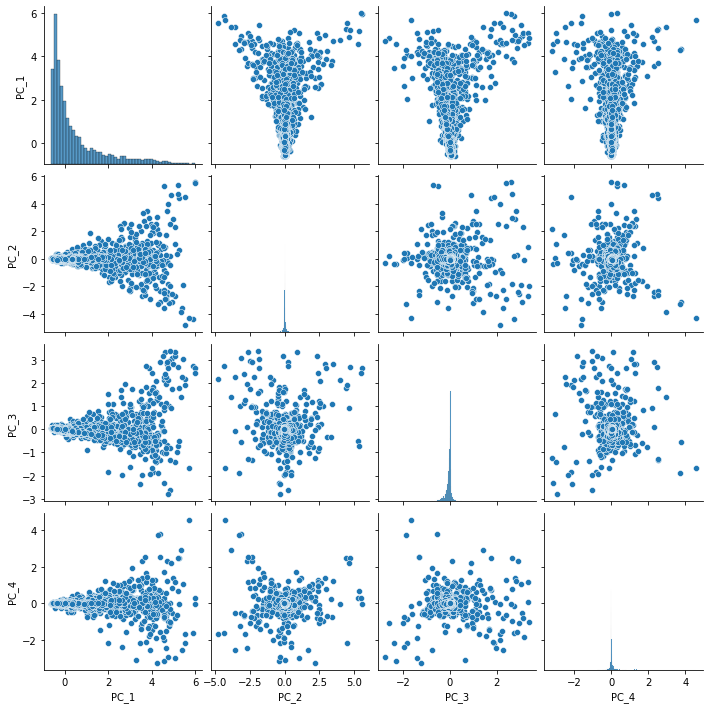

In [59]:
sns.pairplot(pca_test.iloc[:,1:5])

## LLE

### Using Stemming

In [60]:
from sklearn.manifold import LocallyLinearEmbedding

In [61]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

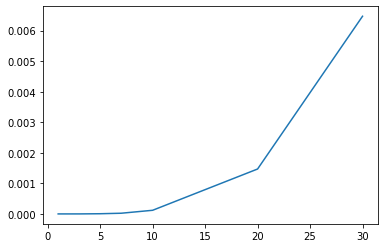

In [62]:
plt.plot(n_components, reconstruction_error)

In [63]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle["Word"] = test_embedding_stem["Word"]
df_lle = df_lle[["Word", "feature1", "feature2", "feature3", "feature4"]]

In [64]:
df_lle.head()

,Word,feature1,feature2,feature3,feature4
0,choic,-0.000026,0.002615,-0.002461,-0.025436
1,author,-0.000019,0.011902,0.021340,0.018139
2,aim,-0.000024,0.005626,0.019261,0.009946
3,rang,-0.000027,0.002396,0.021000,0.017205
4,view,-0.000032,-0.004371,0.021016,0.016270


In [65]:
lle_model.reconstruction_error_

1.8936346093985898e-06

In [ ]:
sns.pairplot(df_lle.iloc[:,1:5])

### Using Lemmatization

In [67]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

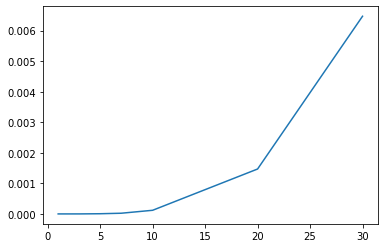

In [68]:
plt.plot(n_components, reconstruction_error)

In [69]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle["Word"] = test_embedding_lem["Word"]
df_lle = df_lle[["Word", "feature1", "feature2", "feature3", "feature4"]]

In [70]:
df_lle.head()

,Word,feature1,feature2,feature3,feature4
0,choice,-0.000026,0.002615,-0.002461,-0.025436
1,author,-0.000019,0.011902,0.021340,0.018139
2,aim,-0.000024,0.005626,0.019261,0.009946
3,range,-0.000027,0.002396,0.021000,0.017205
4,view,-0.000032,-0.004371,0.021016,0.016270


KeyboardInterrupt: 

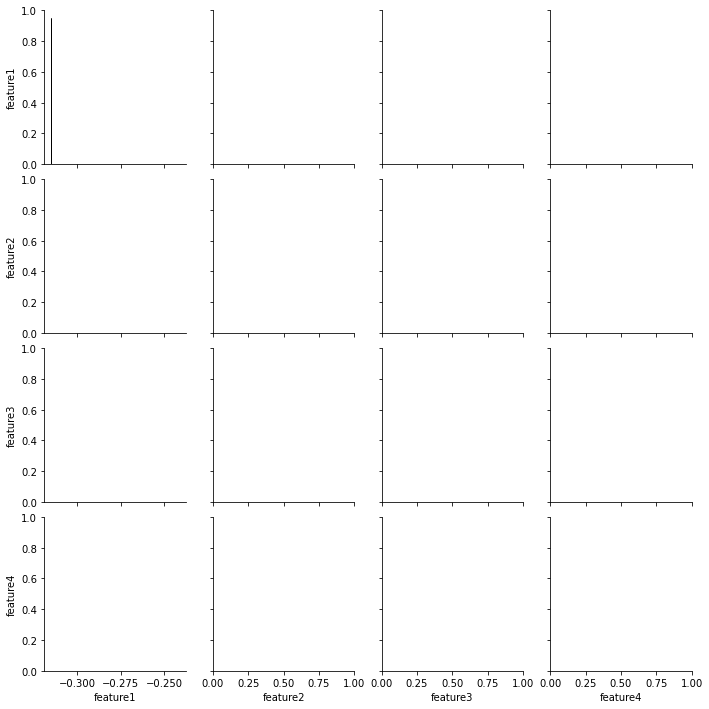

In [71]:
sns.pairplot(df_lle.iloc[:,1:5])

In [ ]:
lle_model.reconstruction_error_

## TSNE

### Using Stemming

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

In [ ]:
df_tsne = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne["Word"] = test_embedding_stem["Word"]
df_tsne = df_tsne[["Word", "feature1", "feature2"]]
df_viz = df_tsne.sample(200, random_state=0)

In [ ]:
df_viz.head()

In [ ]:
tsne_plot(df_viz)

In [ ]:
tsne_model.kl_divergence_

In [ ]:
tsne_model.n_iter_

### Using Lemmatization

In [ ]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

In [ ]:
df_tsne_lem = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne_lem["Word"] = test_embedding_lem["Word"]
df_tsne_lem = df_tsne_lem[["Word", "feature1", "feature2"]]
df_viz2 = df_tsne_lem.sample(200, random_state=0)

In [ ]:
df_viz2.head()

In [ ]:
tsne_plot(df_viz2)

In [ ]:
tsne_model.kl_divergence_

In [ ]:
tsne_model.n_iter_